# Do authors get tougher with experience? Easier?

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('../pitchfork.db')
all_reviews = pd.read_sql('SELECT * FROM reviews', con)
con.close()

First, I need to find the authors with a longer history (where distributional changes could be detected). Here's a barplot to get a sense of how many articles each person tends to write:

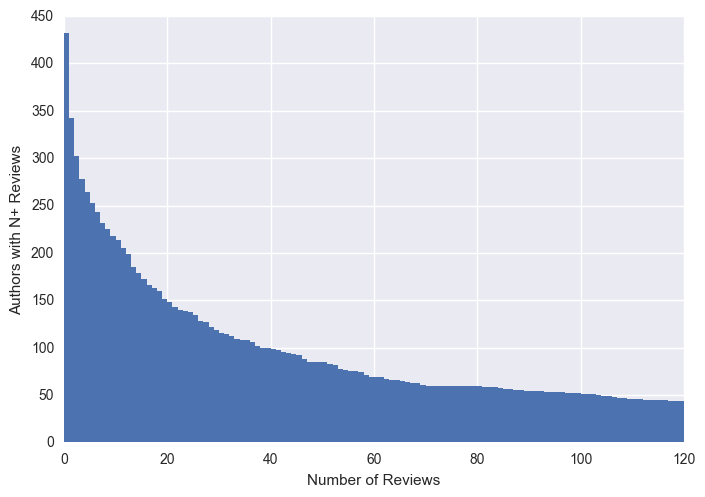

In [2]:
author_groups = all_reviews.groupby('author')
author_counts = author_groups.size().reset_index()

x = range(120)
y = [sum(author_counts[0] > i) for i in x]
plt.bar(x, y, width = 1, edgecolor='none')
plt.xlabel('Number of Reviews')
plt.ylabel('Authors with N+ Reviews')
plt.show()

There's a lot of attrition between 0-70. But it looks most writers who make it to 70 reviews stay on well past 100. Those (about 60) people are going to be the population of interest here.

The next step is to get the other reviewers out of the data, and assign a review order field to each author's data.

In [3]:
# subset data
keep_authors = author_counts.author[author_counts[0] >= 70]
reviews = all_reviews[all_reviews.author.isin(keep_authors)]

# clear out space for review order
reviews = reviews.assign(review_num = pd.Series(index=reviews.index))

# count each author's reviews
author_groups = reviews.groupby('author')
for a, rows in author_groups:
    values = list(reversed(range(rows.shape[0])))
    reviews.set_value(rows.index, 'review_num', values)
    

Okay, let's start with the obvious plot -- average score over review number.

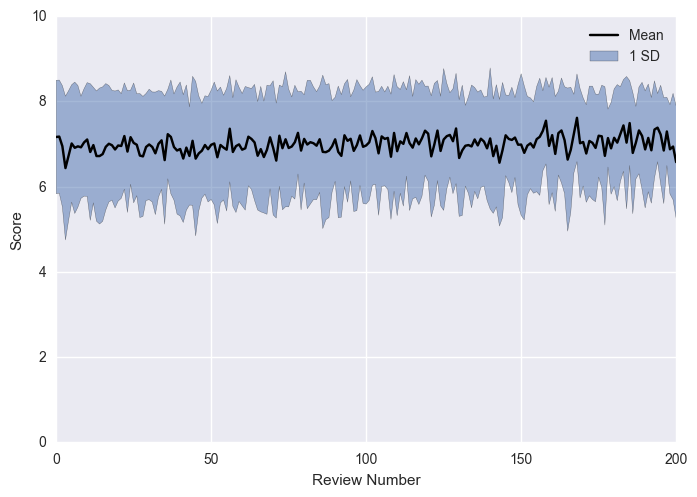

In [4]:
g = reviews.groupby(['review_num'])
table = g['score'].agg(['mean','std', 'count'])
table = table.reset_index()

x = table['review_num']
y = table['mean']

plt.fill_between(x, y + table['std'], y  - table['std'], alpha = 0.5, label = '1 SD')    
plt.plot(x, y, '-', color = 'k', label = 'Mean')
plt.legend()
plt.axis([0, 200, 0, 10])
plt.xlabel('Review Number')
plt.ylabel('Score')
plt.show()

Nothing there! The average score doesn't appear to change with experience. Scores don't become more variable with experience either, so no evidence of divergent paths (some reviewers get tougher, some get easier).

It's possible that experience could drive ratings, but this particular population (who write a lot of articles) were seasoned writers before they started at Pitchfork, so they wouldn't act any differently over time. 

We could look at the inverse group (writers with fewer than 70 reviews), but the attrition is so extreme that you'd have to be skeptical of any account. Anyway, here it is--

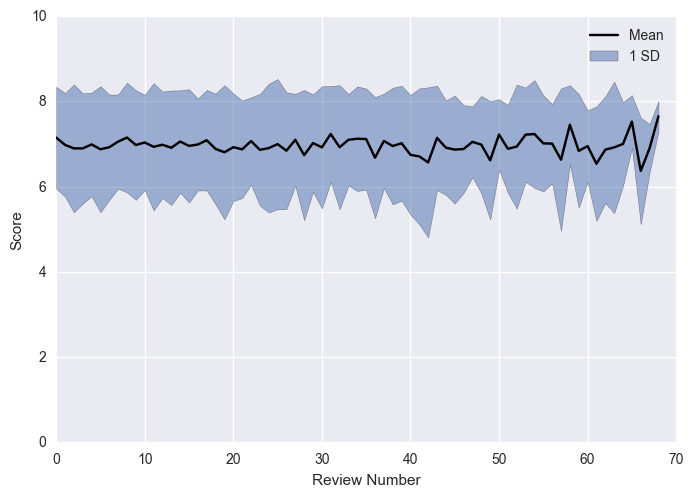

In [5]:
# subset data
keep_authors = author_counts.author[author_counts[0] < 70]
reviews = all_reviews[all_reviews.author.isin(keep_authors)]

# clear out space for review order
reviews = reviews.assign(review_num = pd.Series(index=reviews.index))

# count each author's reviews
author_groups = reviews.groupby('author')
for a, rows in author_groups:
    values = list(reversed(range(rows.shape[0])))
    reviews.set_value(rows.index, 'review_num', values)


# plotting
g = reviews.groupby(['review_num'])
table = g['score'].agg(['mean','std', 'count'])
table = table.reset_index()

x = table['review_num']
y = table['mean']

plt.fill_between(x, y + table['std'], y  - table['std'], alpha = 0.5, label = '1 SD')    
plt.plot(x, y, '-', color = 'k', label = 'Mean')
plt.legend()
plt.axis([0, 70, 0, 10])
plt.xlabel('Review Number')
plt.ylabel('Score')
plt.show()

Also nothing there. Maybe the scores get a little more variable toward the tail end, but you'd expect that given there's fewer data-points.

## Conclusions
There's no evidence of review scores systematically varying as a function of experience. I'm still not convinced that *something* like this doesn't affect a novice reviewer (absence of evidence is not evidence of absence!), but individuals who write for Pitchfork are (presumably) highly qualified / experienced, so these effects wouldn't be visible in their data.